# Cifar (Animal and Vehicle) Classification

# Contents <a id='back'></a>

* [1. Initialisation](#init)
* [2. Load the Images](#load)
* [3. Visualise the Images](#visualisation)
* [4. Modeling](#modeling)
* [5. Model Evaluation](#evaluation)

## 1. Initialisation <a id='init'></a>

In [1]:
import os

# Data manipulation
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Get the images
from tensorflow.keras.datasets import cifar10

# Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [2]:
# Limit GPU Memory Growth
if tf.test.is_built_with_cuda():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

## 2. Load the images <a id='load'></a>

In [3]:
# Load the images
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [4]:
# Check the shapes
print('Shape of X_train', X_train.shape)
print('Shape of y_train', y_train.shape)
print('Shape of X_test', X_test.shape)
print('Shape of y_test', y_test.shape)

Shape of X_train (50000, 32, 32, 3)
Shape of y_train (50000, 1)
Shape of X_test (10000, 32, 32, 3)
Shape of y_test (10000, 1)


In [5]:
# Get the image shape
img_shape = X_train[0].shape
print('Shape of images:', img_shape)

Shape of images: (32, 32, 3)


In [6]:
# Reshape labels
y_train = tf.squeeze(y_train)
y_test = tf.squeeze(y_test)

In [7]:
# Find the number of classes
num_classes = len(tf.unique(y_train)[0])
print('Number of classes:', num_classes)

Number of classes: 10


In [8]:
# Create class names according to https://keras.io/api/datasets/cifar10/
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

## 3. Visualise the Images <a id='visualisation'></a>

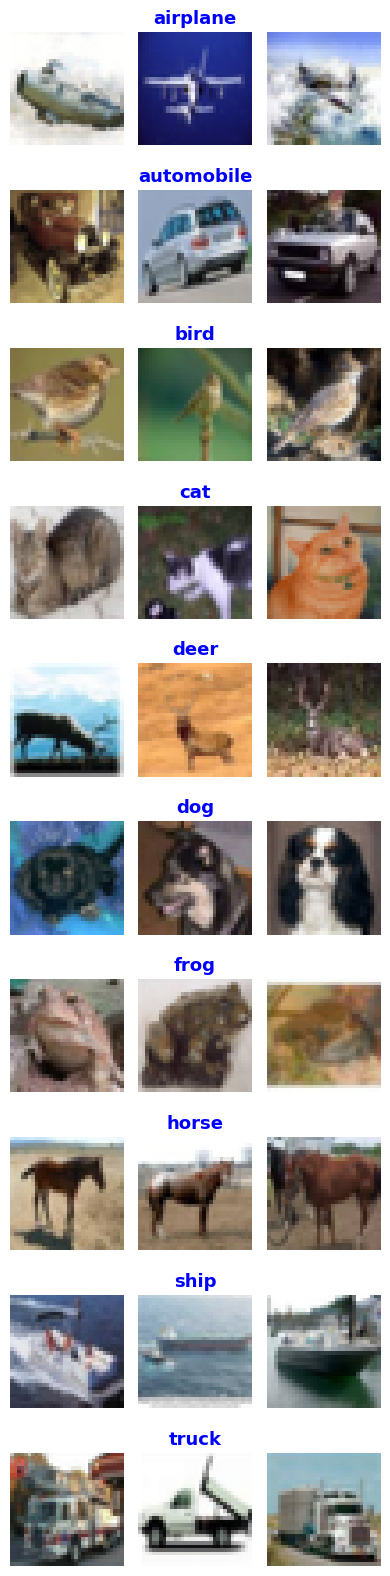

In [9]:
# Have a look at the images
nrows, ncols = num_classes, 3
fig, axs = plt.subplots(nrows, ncols, figsize=(4, 16), sharey=True)

# One class per row
for i in range(nrows):
    # Get the images and labels for the row
    imgs = X_train[y_train == i]
    labels = y_train[y_train == i]
    # Show the images
    for j in range(ncols):
        rand_idx = tf.random.uniform(shape=[], maxval=len(imgs), dtype=tf.int32)
        img = imgs[rand_idx]
        label = labels[rand_idx]

        ax = axs[i][j]
        ax.imshow(img, cmap='gray')
        ax.axis(False)
        if j == 1:
            ax.set_title(class_names[i], fontsize=13, fontweight='bold', color='blue')

plt.tight_layout()
plt.show()

## 4. Modeling <a id='modeling'></a>

Create a function to visualise the losses and accuracy scores of neural network model.

In [10]:
def visualise_loss_accuracy(history, model_name):
    '''
    This function visualise the train and validation losses and accuracies
    '''
    # Set up the figure
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Figure title
    fig.suptitle(f'Train/Validation Losses and Accuracies of {model_name}', fontsize=14, fontweight='bold', y=1.01)

    # Loss
    ax = axs[0]
    ax.plot(history['loss'], label='Train Loss')
    ax.plot(history['val_loss'], label='Validation Loss')
    ax.set_title('Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

    # MAE
    ax = axs[1]
    ax.plot(history['acc'], label='Train Accuracy')
    ax.plot(history['val_acc'], label='Validation Accuracy')
    ax.set_title('Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

    plt.show()

Create a function to store the model and result.

In [11]:
def store_model_result(model, history, result, model_name):
    '''
    This function store the validation accuracy and save the model
    '''
    result[model_name] = {}
    result[model_name]['val_acc'] = max(history["val_acc"])
    best_model[model_name] = model   

In [12]:
# Datagen for training set
aug_datagen = ImageDataGenerator(rescale=1./255,
                                 horizontal_flip=True,
                                 rotation_range=20,
                                 shear_range=0.2,
                                 zoom_range=0.2)

# Datagen for validation and test sets
datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.5)

### Model 1 - CNN

We will first create a classic CNN model.

In [13]:
# Dicts to store various information for later use
result = {}
best_model = {}

# Create a folder to store the model
model_folder = 'models'
os.makedirs(model_folder, exist_ok=True)

In [14]:
# Set up for the modeling process
model_name = 'CNN'
model_path = os.path.join(model_folder, f'{model_name}.keras')

In [15]:
# Create data generators
train_gen = aug_datagen.flow(X_train, y_train, batch_size=32, seed=42)
val_gen = datagen.flow(X_test, y_test, batch_size=32, subset='training', seed=42)

# For reproducibility
tf.keras.utils.set_random_seed(42)

# Create the model
model_1 = Sequential()

# Add the convolution layers
model_1.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=img_shape))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

model_1.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

model_1.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

# Add the flatten layer
model_1.add(Flatten())

# Add fully connected layer to extracted features
model_1.add(Dense(256, activation='relu'))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.25))
model_1.add(Dense(32, activation='relu'))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.25))

# Final layer for prediction
model_1.add(Dense(10, activation='softmax'))

In [16]:
# Compile the model
optimizer = Adam(learning_rate=0.0005)
model_1.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

# Have a look at the model architecture
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 64)        2

In [17]:
# Callbacks
# learning rate
def lr_schedule_1(epoch, learning_rate):
    if epoch < 5:
        return learning_rate
    else:
        return learning_rate * 0.9

lr_scheduler_1 = LearningRateScheduler(lr_schedule_1)

# Model checkpoint
checkpoint_path_1 = model_path
checkpoint_1 = ModelCheckpoint(filepath=checkpoint_path_1,
                               monitor='val_acc',
                               save_best_only=True)

# Early stopping
early_stopping_1 = EarlyStopping(patience=5,
                                 monitor='val_acc',
                                 restore_best_weights=True)

callbacks_1 = [lr_scheduler_1, checkpoint_1, early_stopping_1]

In [18]:
%%time
# Train the model
history_1 = model_1.fit(train_gen, epochs=25, validation_data=val_gen, callbacks=callbacks_1)

# Load the best model
model_1 = load_model(checkpoint_path_1)

Epoch 1/25


1563/1563 [==============================] - 43s 26ms/step - loss: 1.8231 - acc: 0.3554 - val_loss: 1.3634 - val_acc: 0.5078 - lr: 5.0000e-04
Epoch 2/25
1563/1563 [==============================] - 39s 25ms/step - loss: 1.4762 - acc: 0.4726 - val_loss: 1.3628 - val_acc: 0.5086 - lr: 5.0000e-04
Epoch 3/25
1563/1563 [==============================] - 40s 25ms/step - loss: 1.3536 - acc: 0.5188 - val_loss: 1.2441 - val_acc: 0.5526 - lr: 5.0000e-04
Epoch 4/25
1563/1563 [==============================] - 40s 25ms/step - loss: 1.2673 - acc: 0.5570 - val_loss: 1.0171 - val_acc: 0.6398 - lr: 5.0000e-04
Epoch 5/25
1563/1563 [==============================] - 39s 25ms/step - loss: 1.2020 - acc: 0.5816 - val_loss: 0.9586 - val_acc: 0.6604 - lr: 5.0000e-04
Epoch 6/25
1563/1563 [==============================] - 40s 25ms/step - loss: 1.1359 - acc: 0.6040 - val_loss: 1.0576 - val_acc: 0.6198 - lr: 4.5000e-04
Epoch 7/25
1563/1563 [==============================] - 40s 25ms/step - loss: 1.

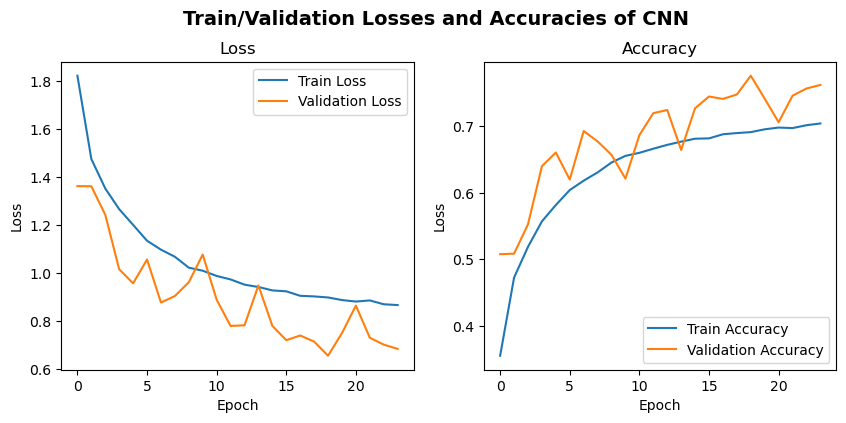

In [19]:
# Visualise the losses and accuracies
visualise_loss_accuracy(history_1.history, model_name)

In [20]:
# Store the validation accuracy and the model
store_model_result(model_1, history_1.history, result, model_name)

### Model 2 - MiniVGGNet

We will recreate a 'mini' version of famous VGG model, as shown in the figure below.

![MiniVGGNet Architecture](https://raw.githubusercontent.com/chongwee0312/learn_deep_learning_tensorflow_pytorch/main/project_04/minivgg.png)

In [21]:
# Set up for the modeling process
model_name = 'MiniVGGNet'
model_path = os.path.join(model_folder, f'{model_name}.keras')

In [22]:
# Create data generators
train_gen = aug_datagen.flow(X_train, y_train, batch_size=32, seed=42)
val_gen = datagen.flow(X_test, y_test, batch_size=32, subset='training', seed=42)

# For reproducibility
tf.keras.utils.set_random_seed(42)

# Create the model
model_2 = Sequential()

# Add the convolution layers
model_2.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=img_shape))
model_2.add(BatchNormalization())
model_2.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.5))

model_2.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.5))

# Add the flatten layer
model_2.add(Flatten())

# Add fully connected layer to extracted features
model_2.add(Dense(512, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))

# Final layer for prediction
model_2.add(Dense(10, activation='softmax'))

In [23]:
# Compile the model
optimizer = Adam()
model_2.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

# Have a look at the model architecture
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_5 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_6 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                      

In [24]:
# Callbacks
# learning rate
def lr_schedule_2(epoch, learning_rate):
    if epoch < 5:
        return learning_rate
    else:
        return learning_rate * 0.9

lr_scheduler_2 = LearningRateScheduler(lr_schedule_2)

# Model checkpoint
checkpoint_path_2 = model_path
checkpoint_2 = ModelCheckpoint(filepath=checkpoint_path_2,
                               monitor='val_acc',
                               save_best_only=True)

# Early stopping
early_stopping_2 = EarlyStopping(patience=5,
                                 monitor='val_acc',
                                 restore_best_weights=True)

callbacks_2 = [lr_scheduler_2, checkpoint_2, early_stopping_2]

In [25]:
%%time
# Train the model
history_2 = model_2.fit(train_gen, epochs=40, validation_data=val_gen, callbacks=callbacks_2)

model_2 = load_model(checkpoint_path_2)

Epoch 1/40
1563/1563 [==============================] - 99s 62ms/step - loss: 1.7130 - acc: 0.4153 - val_loss: 1.7902 - val_acc: 0.4148 - lr: 0.0010
Epoch 2/40
1563/1563 [==============================] - 97s 62ms/step - loss: 1.3088 - acc: 0.5332 - val_loss: 1.2720 - val_acc: 0.5590 - lr: 0.0010
Epoch 3/40
1563/1563 [==============================] - 97s 62ms/step - loss: 1.1865 - acc: 0.5805 - val_loss: 1.3513 - val_acc: 0.5512 - lr: 0.0010
Epoch 4/40
1563/1563 [==============================] - 97s 62ms/step - loss: 1.0937 - acc: 0.6146 - val_loss: 1.0241 - val_acc: 0.6542 - lr: 0.0010
Epoch 5/40
1563/1563 [==============================] - 98s 63ms/step - loss: 1.0435 - acc: 0.6313 - val_loss: 0.9547 - val_acc: 0.6766 - lr: 0.0010
Epoch 6/40
1563/1563 [==============================] - 97s 62ms/step - loss: 0.9869 - acc: 0.6545 - val_loss: 0.8980 - val_acc: 0.7018 - lr: 9.0000e-04
Epoch 7/40
1563/1563 [==============================] - 97s 62ms/step - loss: 0.9333 - acc: 0.6722 - v

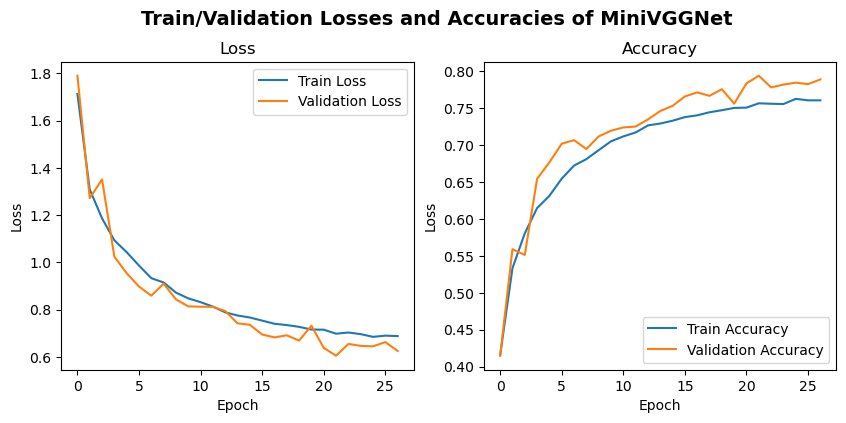

In [26]:
# Visualise the losses and accuracies
visualise_loss_accuracy(history_2.history, model_name)

In [27]:
# Store the validation accuracy and the model
store_model_result(model_2, history_2.history, result, model_name)

### Model 3 - Transfer Learning from MobileNetV2

Finally, we well employ the transfer learning technique by importing the pretrained MobileNEtV2 model and retraining all the parameters. Since the weights have been pretrained, we can obtain a good model with less training time.

In [28]:
# Set up for the modeling process
model_name = 'MoblileNetV2'
model_path = os.path.join(model_folder, f'{model_name}.keras')

In [45]:
# Create data generators
train_gen = aug_datagen.flow(X_train, y_train, batch_size=32, seed=42)
val_gen = datagen.flow(X_test, y_test, batch_size=32, subset='training', seed=42)

# Load the pretrained VGG16 model without fully connected layers
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=img_shape)

# Have a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 16, 16, 32)           864       ['input_4[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 16, 16, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 16, 16, 32)           0         ['bn_Conv1[

In [46]:
# For reproducibility
tf.keras.utils.set_random_seed(42)

# Create the model
model_3 = Sequential()

# Add the base model MobileNetV2
model_3.add(base_model)

# Add a global average pooling layer
model_3.add(GlobalAveragePooling2D())
model_3.add(Dropout(0.25))

# Add fully connected layer to extracted features
model_3.add(Dense(64, activation='relu', kernel_regularizer=L1L2(l1=1, l2=1)))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.25))

# Final layer for prediction
model_3.add(Dense(10, activation='softmax'))

In [47]:
# Compile the model
optimizer = Adam()
model_3.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

# Have a look at the model architecture
model_3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1, 1, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_14 (Dropout)        (None, 1280)              0         
                                                                 
 dense_11 (Dense)            (None, 64)                81984     
                                                                 
 batch_normalization_13 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                      

In [48]:
def lr_schedule_3(epoch, learning_rate):
    init_lr = 1e-5
    min_lr = 1e-6
    max_lr = 5e-4

    rampup_epochs = 3
    sustain_epochs = 2
    exp_decay = 0.8
    
    if epoch < rampup_epochs:
        return (max_lr - init_lr) / (rampup_epochs) * epoch + init_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr

lr_scheduler_3 = LearningRateScheduler(lr_schedule_3)


# Model checkpoint
checkpoint_path_3 = model_path
checkpoint_3 = ModelCheckpoint(filepath=checkpoint_path_3,
                               monitor='val_acc',
                               save_best_only=True)

# Early stopping
early_stopping_3 = EarlyStopping(patience=5,
                                 monitor='val_acc',
                                 restore_best_weights=True)

callbacks_3 = [lr_scheduler_3, checkpoint_3, early_stopping_3]

In [49]:
%%time
# Train the model
history_3 = model_3.fit(train_gen, epochs=30, validation_data=val_gen, callbacks=callbacks_3)

model_3 = load_model(checkpoint_path_3)

Epoch 1/30
1563/1563 [==============================] - 178s 104ms/step - loss: 2234.1467 - acc: 0.1198 - val_loss: 1666.2263 - val_acc: 0.1174 - lr: 1.0000e-05
Epoch 2/30
1563/1563 [==============================] - 154s 98ms/step - loss: 113.8073 - acc: 0.2563 - val_loss: 5.7257 - val_acc: 0.3450 - lr: 1.7333e-04
Epoch 3/30
1563/1563 [==============================] - 155s 99ms/step - loss: 7.8167 - acc: 0.3838 - val_loss: 7.2934 - val_acc: 0.4290 - lr: 3.3667e-04
Epoch 4/30
1563/1563 [==============================] - 153s 98ms/step - loss: 9.1074 - acc: 0.4697 - val_loss: 8.8984 - val_acc: 0.5246 - lr: 5.0000e-04
Epoch 5/30
1563/1563 [==============================] - 155s 99ms/step - loss: 8.4481 - acc: 0.5473 - val_loss: 8.7902 - val_acc: 0.4874 - lr: 5.0000e-04
Epoch 6/30
1563/1563 [==============================] - 159s 101ms/step - loss: 8.1412 - acc: 0.5849 - val_loss: 8.6166 - val_acc: 0.5806 - lr: 5.0000e-04
Epoch 7/30
1563/1563 [==============================] - 155s 99ms/

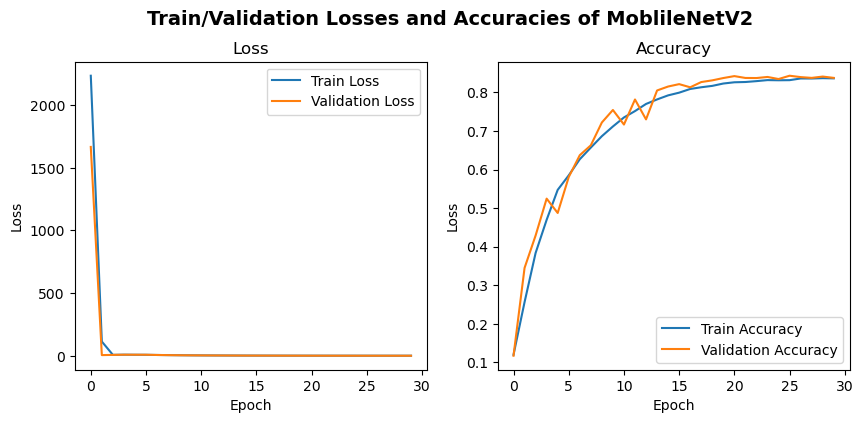

In [50]:
# Visualise the losses and accuracies
visualise_loss_accuracy(history_3.history, model_name)

In [51]:
# Store the validation accuracy and the model
store_model_result(model_3, history_3.history, result, model_name)

## 5. Model Evaluation <a id='evaluation'></a>

In [52]:
# Evaluate the models on the test set
for model in best_model:
    test_gen = datagen.flow(X_test, y_test, batch_size=32, subset='validation', seed=42)
    test_acc = best_model[model].evaluate(test_gen)[1]
    result[model]['test_acc'] = test_acc

157/157 [==============================] - 5s 17ms/step - loss: 0.8838 - acc: 0.8404


In [53]:
# Show the final accuracies
result_df = pd.DataFrame(result).transpose()

result_df

,val_acc,test_acc
CNN,0.7756,0.7608
MiniVGGNet,0.7938,0.7852
MoblileNetV2,0.8432,0.8404


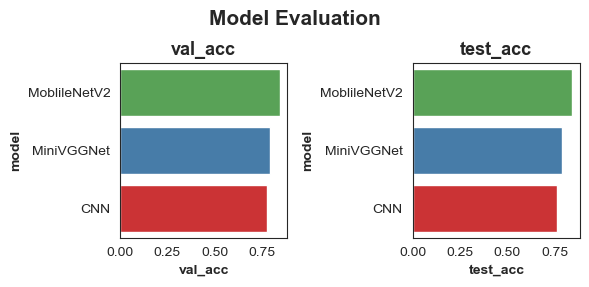

In [54]:
# Visualise the final result
plot_results = result_df.columns
nrows, ncols = 1, 2

sns.set_style('white')
fig, axs = plt.subplots(nrows, ncols, figsize=(6, 3))

plt.suptitle('Model Evaluation', fontsize=15, fontweight='bold', y=0.94)

# Assign colors for models
colors = sns.color_palette('Set1')
model_colors = {}
for i, model in enumerate(result_df.index):
    color = colors[i % len(colors)]
    model_colors[model] = color

for i in range(ncols):
    plot_name = plot_results[i]
    plot_data = result_df[[plot_name]].sort_values(plot_name, ascending=False)

    ax = axs[i]
    sns.barplot(y=plot_data.index, x=plot_data[plot_name], palette=model_colors, hue=plot_data.index, ax=ax)        
    ax.set_title(plot_name, fontsize=13, fontweight='bold')
    ax.set_xlabel(plot_name, fontweight='bold')
    ax.set_ylabel('model', fontweight='bold')
        
plt.tight_layout()
plt.show()

In [55]:
# Get the predict probability and prediction of the final model on the test set
test_gen = datagen.flow(X_test, y_test, batch_size=32, subset='validation', seed=42)
pred_proba = best_model['MoblileNetV2'].predict(test_gen)
y_pred = tf.argmax(pred_proba, axis=1, output_type=tf.int32)

157/157 [==============================] - 4s 17ms/step


In [56]:
# Separate the test gens into X and y
test_gen = datagen.flow(X_test, y_test, batch_size=32, subset='validation', seed=42)
X_test_final = []
y_test_final = []
for i in range(len(test_gen)):
    X_test_final.extend(test_gen[i][0])
    y_test_final.extend(test_gen[i][1])

X_test_final = tf.convert_to_tensor(X_test_final)
y_test_final = tf.convert_to_tensor(y_test_final)

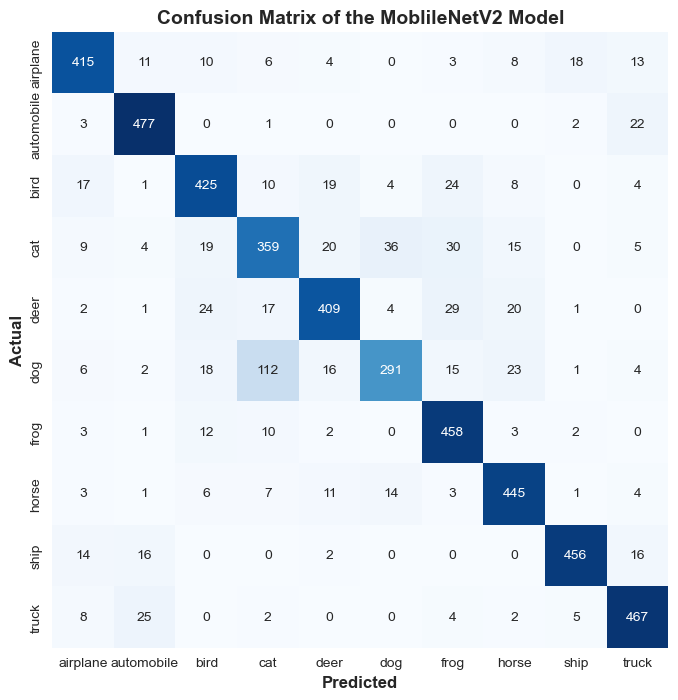

In [57]:
# Plot the confusion matrix of the final model
plt.figure(figsize=(8, 8))

cm = tf.math.confusion_matrix(y_test_final, y_pred)
sns.heatmap(cm, annot=True, fmt='.0f', square=True, cmap='Blues', cbar=False)
plt.title('Confusion Matrix of the MoblileNetV2 Model', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.xticks(tf.range(0.5, 10, 1), class_names)
plt.yticks(tf.range(0.5, 10, 1), class_names)

plt.show()

Dogs and cats are most frequently misclassied as other objects, especially there are 112 dogs misclassified as cats. 

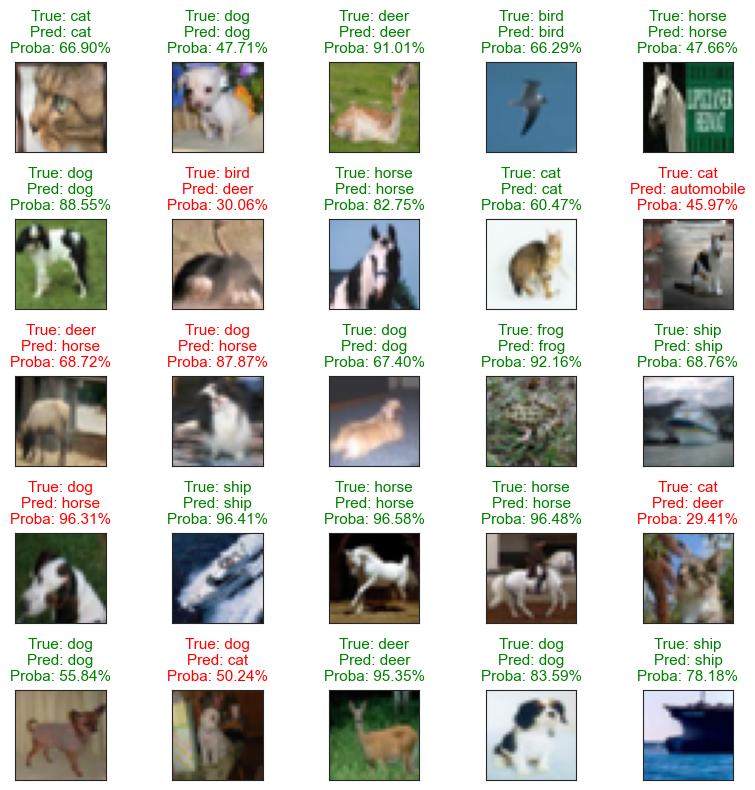

In [58]:
# Comment out the line below to get random examples
tf.random.set_seed(42)

# Set up the figure
nrows, ncols = 5, 5
fig, axs = plt.subplots(nrows, ncols, figsize=(8, 8), sharey=True)

# Show the images and predictions
for i in range(nrows):
    for j in range(ncols):
        rand_idx = tf.random.uniform(shape=[], maxval=len(y_test_final), dtype=tf.int32)
        img = X_test_final[rand_idx]
        label = y_test_final[rand_idx]
        prediction = y_pred[rand_idx]
        proba = pred_proba[rand_idx, prediction]
        
        ax = axs[i][j]
        ax.imshow(img, cmap='gray')        
        ax.set_yticks([])
        ax.set_xticks([])

        # Green for correct prediction, red for wrong prediction
        if prediction == label:
            color = 'green'
        else:
            color = 'red'
        ax.set_title(f'True: {class_names[label]}\nPred: {class_names[prediction]}\nProba: {proba:.2%}',
                     color=color, fontsize=11)

plt.tight_layout()
plt.show()